<a href="https://colab.research.google.com/github/langfordzd/burst_regimes/blob/main/parameter_picks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First we need to install and import a few things



In [ ]:
!pip install neurodsp
!pip install bycycle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from bycycle.features import compute_features
from neurodsp.sim import sim_powerlaw
from neurodsp.utils import set_random_seed
import itertools
from multiprocessing import Pool, cpu_count
import pandas as pd
import seaborn as sns
from neurodsp.sim import sim_oscillation
from neurodsp.timefrequency import amp_by_time
from scipy import stats
import matplotlib as mpl
import matplotlib.gridspec as gridspec
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 18

In [ ]:
def f_cf(signal,thresh):
    #This function will be called below and just takes the signal and threshold
    #and then returns how many bursts were found.

    threshold_kwargs = {'amp_fraction_threshold': 0.0,
                   'amp_consistency_threshold': thresh[0],
                   'period_consistency_threshold': thresh[1],
                   'monotonicity_threshold': thresh[2],
                   'min_n_cycles': thresh[3]}

    sf = compute_features(signal[1], s_rate,
                              (15,29), threshold_kwargs=threshold_kwargs,
                              return_samples=True)
    count = 0
    bursts = sf[sf['is_burst']]
    if any(bursts['is_burst']):
        burst_list = np.split(bursts, np.flatnonzero(np.diff(bursts.index) != 1) + 1)
        count = len(burst_list)

    return count

#What are we doing?
This next block of code sets up an exhaustive grid with the AC, PC, and MT parameters. We already reguralize a bit at this point - not letting the parameters go below 0.2 or above 0.8, becasue they are too liberal or conservative. It also goes in setps of 0.2, and we have either 2 cycles or 3 cycles. The grid will then have 128 unique sets of parameters. Basically, we have these 128 sets, and then we will simulate noise 'trials' (n_noises), and we then for each trial and each parameter sets we calculate the number of bursts.

In [ ]:
threshs = np.around(np.arange(0.2,0.8+0.1,0.2),3).tolist()
wte = list(itertools.product(threshs, repeat= 3))
wte2 = [e + tuple([2]) for e in wte]
wte3 = [e + tuple([3]) for e in wte]
wte = wte2+wte3

So what we do is calculate 1 sec trials n_noises times, you can think of it as a trial. In the end we want to say something like per trial or per second this set of parameters will 'find' a number of bursts in coloured noise.[link text](https://)


In [ ]:
set_random_seed(1)
n_noises = 1000
secs = 1
s_rate = 250
signals = [(i,sim_powerlaw(secs, s_rate, exponent=-2)) for i in range(0,n_noises)]
sig_eval_product = list(itertools.product(signals, wte))


**Note: this will take a long time if you set n_noises to be 1000.** It will be much faster to just grab the results using curl.


In [ ]:
#num_cores = cpu_count()
#pool = Pool(processes=num_cores)
#result =  pool.starmap(f_cf, sig_eval_product)
#pool.close()
#pool.join()

In [1]:
!curl -L -J -O 'https://osf.io/k9bv8/download'
import pickle
with open("result_noise.pkl", "rb") as fp:
    result = pickle.load(fp)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   469  100   469    0     0    772      0 --:--:-- --:--:-- --:--:--   771
100  250k  100  250k    0     0   107k      0  0:00:02  0:00:02 --:--:--  650k


In [ ]:
wte_map = [x[1] for x in sig_eval_product]
num_map = [x[0][0] for x in sig_eval_product]
answer = [tuple([b])+e for b,e in zip(result,wte_map)]
together = pd.DataFrame(answer,columns=['count', 'ac', 'pc', 'mt','cys'])
together['noise'] = num_map
rands = 1000 #times to randomize
exp_size = 100 #trials
s = []
import random
for _ in range(rands):
    rs = random.sample(range(0, n_noises), exp_size)
    selec = together.loc[together['noise'].isin(rs)]
    s_ = pd.DataFrame(selec.groupby(['ac', 'pc', 'mt','cys'],as_index=False)['count'].mean())
    s.append(s_)

temp = pd.concat(s)
pertrialavg = pd.DataFrame(temp.groupby(['ac', 'pc', 'mt','cys'],as_index=False)['count'].mean())
#sns.pairplot(pertrialavg, y_vars="count", x_vars=a.columns.values)

What we did was simulate 1000 s (or trials) of noise and then we randomly kept drawing a tenth of it, counting up the number of bursts, and taking the average - for each of the 128 combinations. What we end up with are for each combination the average number of bursts per trial. You can plot them out as below and see that for some combinations you can detect a burst where there wasn't a burst intended. In general we think this should be avoided. What we did was reguralized the maps to not produce more than 1 burst per 10 seconds of data. In fact, though, a lot of these are too conservative and are probably a waste of computing, so we discarded combinations that didn't produce at least 1 burst every ~30 seconds on average. In the simulations these seem to work quite well.

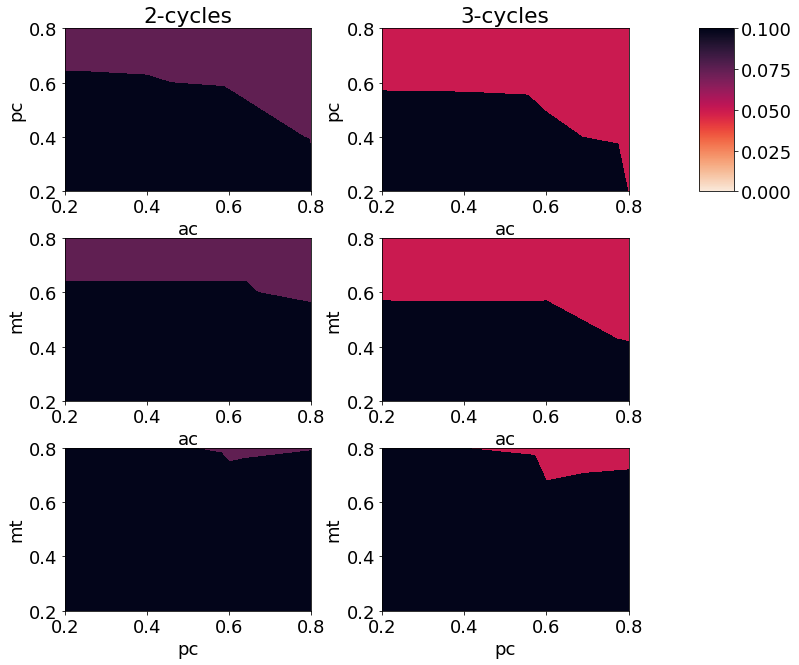

In [ ]:
p2 = pertrialavg[pertrialavg['cys'] == 2]
p3 = pertrialavg[pertrialavg['cys'] == 3]

vmax=0.1
c = sns.color_palette("rocket_r", as_cmap=True)
fig = plt.figure(1, figsize=(12, 12))
gs = gridspec.GridSpec(10, 7)
gs.update(wspace=2, hspace=2)

xtr = fig.add_subplot(gs[0:3, 0:3])
xtr.set_title('2-cycles')
m = xtr.tricontourf(p2.pc, p2.ac, p2['count'],
                   levels=14, cmap=c,
                    vmin=0, vmax=vmax)
xtr.set(ylabel='pc',xlabel='ac')
#fig.colorbar(m,ax=xtr)

xtr = fig.add_subplot(gs[3:6, 0:3])
m = xtr.tricontourf(p2.mt, p2.ac, p2['count'],
                   levels=14, cmap=c,
                    vmin=0, vmax=vmax)
xtr.set(ylabel='mt',xlabel='ac')
#fig.colorbar(m,ax=xtr)

xtr = fig.add_subplot(gs[6:9, 0:3])
m = xtr.tricontourf(p2.mt, p2.pc, p2['count'],
                   levels=14, cmap=c,
                    vmin=0, vmax=vmax)
xtr.set(ylabel='mt',xlabel='pc')
#fig.colorbar(m,ax=xtr)

xtr = fig.add_subplot(gs[0:3, 3:6])
xtr.set_title('3-cycles')
m = xtr.tricontourf(p3.pc, p3.ac, p3['count'],
                   levels=14, cmap=c,
                    vmin=0, vmax=vmax)
xtr.set(ylabel='pc',xlabel='ac')
#fig.colorbar(m,ax=xtr)

xtr = fig.add_subplot(gs[3:6, 3:6])
m = xtr.tricontourf(p3.mt, p3.ac, p3['count'],
                   levels=14, cmap=c,
                    vmin=0, vmax=vmax)
xtr.set(ylabel='mt',xlabel='ac')
#fig.colorbar(m,ax=xtr)


xtr = fig.add_subplot(gs[6:9, 3:6])
m = xtr.tricontourf(p3.mt, p3.pc, p3['count'],
                   levels=14, cmap=c,
                    vmin=0, vmax=vmax)
xtr.set(ylabel='mt',xlabel='pc')

xtr = fig.add_subplot(gs[0:3, 6:7])
cb = mpl.colorbar.ColorbarBase(xtr, orientation='vertical',cmap=c,norm=mpl.colors.Normalize(0, vmax))


In [ ]:
#import plotly.express as pex
#my_plot = pex.scatter_3d(pertrialavg, x='ac',y='pc',z='mt',color='count')
#my_plot.show()

# How to choose amongst our parameters?
There are, when all reguralization is done, still 21 combinations of parameters. How should we choose between them? There are a few ways to think about doing this. We chose to simply, for each 2-cycle or 3-cycles set, take the one that produced the highest correlation on average. Below you see a 1 second signal and then the amplitude envelope of that signal, what we did was fit each combination and reconstruct where the detected burst turned off or on and correlated it with the envelope.

Text(4000, 0.5, 'r= -0.17')

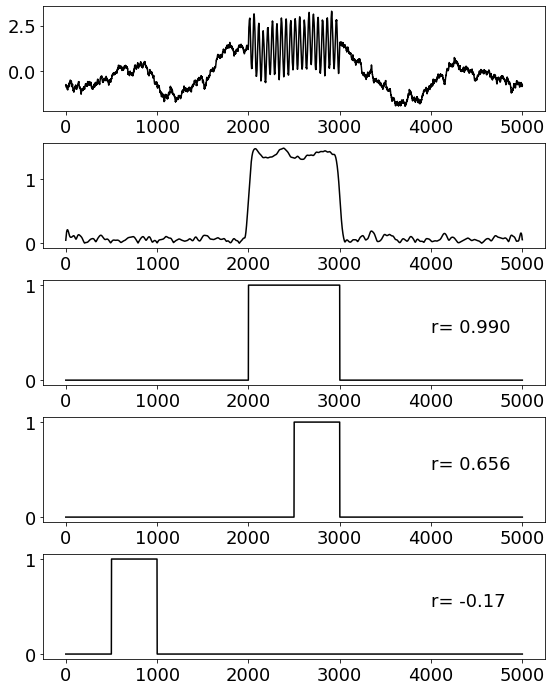

In [ ]:
osc = sim_oscillation(n_seconds=1, fs=1000, freq=20,phase=0)
noise = sim_powerlaw(n_seconds=5, fs=1000)
sig = np.pad(osc, (2000, 2000), 'constant', constant_values=(0))
signal = sig+noise
amp = amp_by_time(signal,fs=1000,f_range=(15, 29),remove_edges=False)
w = np.ones(1000)
b1 = np.pad(w, (2000, 2000), 'constant', constant_values=(0))
w = np.ones(500)
b2 = np.pad(w, (2500, 2000), 'constant', constant_values=(0))
w = np.ones(500)
b3 = np.pad(w, (500, 4000), 'constant', constant_values=(0))

fig = plt.figure(1, figsize=(9, 12))
gs = gridspec.GridSpec(10, 2)
gs.update(wspace=0.7, hspace=0.9)
xtr = fig.add_subplot(gs[0:2, 0:2])
xtr.plot(signal,"k-")
xtr = fig.add_subplot(gs[2:4, 0:2])
xtr.plot(amp,"k-")
xtr = fig.add_subplot(gs[4:6, 0:2])
xtr.plot(b1,"k-")
xtr.annotate('r= '+str(stats.pearsonr(b1, amp)[0])[:5],xy=(4000,0.5))
xtr = fig.add_subplot(gs[6:8, 0:2])
xtr.plot(b2,"k-")
xtr.annotate('r= '+str(stats.pearsonr(b2, amp)[0])[:5],xy=(4000,0.5))
xtr = fig.add_subplot(gs[8:10, 0:2])
xtr.plot(b3,"k-")
xtr.annotate('r= '+str(stats.pearsonr(b3, amp)[0])[:5],xy=(4000,0.5))

We then looked at the 2-cycle and 3-cycle bursts that were recovered and included the ones that were not overlapping.